# **Radiosonde Vertical Profiles for SWEX IOP #10**
## This notebook performs the following tasks:
> - #### Uses a created function to average and plot a time-height figure for both the Rancho Alegre (Visala sounding system) and Montecito Fire Deparment (GRAW sounding system) radiosonde launch sites during SWEX IOP #10.

## **Import Packages**
### Links to documentation for packages:
> - #### [pathlib](https://docs.python.org/3/library/pathlib.html) | [numpy](https://numpy.org/doc/1.21/) | [pandas](https://pandas.pydata.org/pandas-docs/version/1.3.5/) | [xarray](https://docs.xarray.dev/en/stable/) | [matplotlib](https://matplotlib.org/3.5.3/index.html) | [metpy](https://unidata.github.io/MetPy/latest/index.html)
> - #### Documentation for packages linked above should mostly correspond to the most stable versions, which may not be the exact versions used when creating this notebook.
> - #### Comments are also included in the actual code cells. Some comments contain links that point to places where I copied or adapted code to fit my needs. Although I tried to these include links for all instancs of copying, it is possible that there may code snippets that I did not do this for.

In [1]:
#----------------------------------------------------------------------------------------------------------------------
#Import entire packages
import pathlib
import warnings
import numpy as np
import pandas as pd
import xarray as xr

#matplotlib imports
import matplotlib.font_manager
import matplotlib.pyplot as plt

#metpy imports
from metpy.units import units
from metpy.calc import gradient_richardson_number, mixing_ratio_from_relative_humidity

#function notebook
%run ./functions_swex_iop_10.ipynb
#----------------------------------------------------------------------------------------------------------------------

ERROR 1: PROJ: proj_create_from_database: Open of /home/sbarc/students/mariandob/mambaforge/envs/swex/share/proj failed


## **Define locations to Rancho Alegre and Montecito Fire Department #2 radiosonde files**
### **Data Information:**
> - #### **Rancho Alegre: Visala RS-41 Radiosondes (Institution: National Center for Atmospheric Research)**
>> - #### These radiosondes were launched at the Rancho Alegre and Sedgwick Reserve Integrated Sounding System (ISS) stations that were provided and maintained by personel from the National Center for Atmospheric Research (NCAR) for the entire duration of the SWEX campaign. For IOP #10 these radiosondes were only launched at Rancho Alegre.
> - #### **Montecito Fire Department #2: GRAW Radiosondes (Instituion: San Jose State University)**
>> - #### These radiosondes were launched from both Santa Barbara County Fire Station #38 and the Santa Barbara County Fire Department Headquarters during the SWEX campaign. Radiosondes were provided and maintained by personel from San Jose State University (SJSU). For IOP #10 these radiosondes were launched at a new fire station (Montecito Fire Station #2), to better capture Sundowner winds over a more eastern location along the Santa Ynez mountains.

In [3]:
#----------------------------------------------------------------------------------------------------------------------
#Define paths/globs to various radiosonde file locations
path_to_rancho_radiosonde_files    = sorted(pathlib.Path('./data_swex/observations_air/iop_10_radiosonde_v1_rancho_individual_files/').glob('*.nc'))
path_to_montecito_radiosonde_files = sorted(pathlib.Path('./data_swex/observations_air/iop_10_radiosonde_v0_mfs2_individual_files/').glob('*.txt'))

#Display globs to make sure we have files
display(path_to_rancho_radiosonde_files[0])
display(path_to_montecito_radiosonde_files[0])
#----------------------------------------------------------------------------------------------------------------------

PosixPath('data_swex/observations_air/iop_10_radiosonde_v1_rancho_individual_files/NCAR_SWEX2022_ISS2_RS41_v1_20220512_230011.nc')

PosixPath('data_swex/observations_air/iop_10_radiosonde_v0_mfs2_individual_files/SWEX2022_Mont_GRAW_v0_20220512_230022.txt')

## **Compute and plot vertically averaged radiosonde variable(s) for Rancho Alegre over launches that occurred during IOP #10**
### Notes
> - #### We must use two different methods for the Visala (Rancho Alegre) and GRAW (Montecito Fire Department) files since the Rancho Alegre files are NetCDF and the Montecito files are txt files. 
> - #### For the Rancho Alegre radiosondes, there is an actual variable that corresponds to height above mean sea level. We use this variable to compute a height above ground level variable by simply subtracting the first "height above mean sea level" value from the entire array of values (see cell).

In [4]:
#----------------------------------------------------------------------------------------------------------------------
#Create a empty list to store each radiosonde launch date/time
all_rancho_radiosondes_dates = []

#Create a empty list to store each averaged met variable
all_rancho_radiosondes_wind_speed_ms_averaged     = []
all_rancho_radiosondes_uwind_ms_averaged          = []
all_rancho_radiosondes_vwind_ms_averaged          = []
all_rancho_radiosondes_pot_temp_k_averaged        = []
all_rancho_radiosondes_mix_ratio_g_averaged       = []
all_rancho_radiosondes_grad_richardson_averaged   = []
#----------------------------------------------------------------------------------------------------------------------
#Create a loop to average each file on equally spaced grids in the vertical
for single_rancho_radiosonde_index, single_rancho_radiosonde_file in enumerate(path_to_rancho_radiosonde_files):

    #Use radiosonde filename to create a list of pandas datetimes that correspond to the date/time that each radiosonde was launched
    all_rancho_radiosondes_dates.append(pd.to_datetime(str(single_rancho_radiosonde_file)[-18:-10]+str(single_rancho_radiosonde_file)[-9:-4], format='%Y%m%d%H%M%S'))
    
    #Open NetCDF radiosonde file
    nc_rancho_file = xr.open_dataset(single_rancho_radiosonde_file)

    #Grab the column that corresponds to height above mean sea level (units: m)
    single_rancho_radiosonde_height_above_msl_m = nc_rancho_file['alt']

    #Convert to height above ground level by subtracting the first height above mean sea level from every entry (units: m)
    single_rancho_radiosonde_height_above_grd_m = single_rancho_radiosonde_height_above_msl_m - single_rancho_radiosonde_height_above_msl_m[0]

    #Grab meteorological variable(s) we want
    single_rancho_radiosonde_pressure_hpa  = nc_rancho_file['pres']          #pressure (units: hPa)
    single_rancho_radiosonde_wind_speed_ms = nc_rancho_file['wspd']          #wind speed (units: m/s)
    single_rancho_radiosonde_uwind_ms      = nc_rancho_file['u_wind']        #u-component of wind (units: m/s)
    single_rancho_radiosonde_vwind_ms      = nc_rancho_file['v_wind']        #v-component of wind (units: m/s)
    single_rancho_radiosonde_temp_k        = nc_rancho_file['tdry']+273.15   #air temperature (units: converted from °C to K)
    single_rancho_radiosonde_relh_decimal  = nc_rancho_file['rh']/100        #relative humidity (units: converted from % to decimal)
    
    #Computation of potential temperature for single radiosonde
    #https://en.wikipedia.org/wiki/Potential_temperature
    reference_pres_hpa = 1000
    single_rancho_radiosonde_pot_temp_k   = single_rancho_radiosonde_temp_k*((reference_pres_hpa/single_rancho_radiosonde_pressure_hpa)**0.286)
    
    #Computation of mixing ratio for single radiosonde
    single_rancho_radiosonde_mix_ratio_g = mixing_ratio_from_relative_humidity(single_rancho_radiosonde_pressure_hpa.values*units.hectopascal, 
                                                                               single_rancho_radiosonde_temp_k.values*units.kelvin, 
                                                                               single_rancho_radiosonde_relh_decimal.values).to('g/kg')
    
    #Define additional inputs into vertical averaging function
    low_altitude  = 0     #Start height from ground level of our evenly spaced altitude array (units: can be any, as long as consistent with raw data)
    high_altitude = 4000 #End height from ground level of our evenly spaced altitude array (units: can be any, as long as consistent with raw data)
    vertical_res  = 50    #Requested vertical resolution for our function (units: can be any, as long as consistent with raw data)

    #Run our vertical averaging function
    single_rancho_radiosonde_height_above_grd_m_midpoint, single_rancho_radiosonde_wind_speed_ms_averaged = vertical_resolution_averaging_radiosonde(low_altitude, high_altitude, vertical_res, single_rancho_radiosonde_height_above_grd_m, single_rancho_radiosonde_wind_speed_ms, radiosonde_altitude_array_evenly_spaced_midpoint_bool=True)
    single_rancho_radiosonde_uwind_ms_averaged          = vertical_resolution_averaging_radiosonde(low_altitude, high_altitude, vertical_res, single_rancho_radiosonde_height_above_grd_m, single_rancho_radiosonde_uwind_ms,    radiosonde_altitude_array_evenly_spaced_midpoint_bool=False)
    single_rancho_radiosonde_vwind_ms_averaged          = vertical_resolution_averaging_radiosonde(low_altitude, high_altitude, vertical_res, single_rancho_radiosonde_height_above_grd_m, single_rancho_radiosonde_vwind_ms,    radiosonde_altitude_array_evenly_spaced_midpoint_bool=False)
    single_rancho_radiosonde_pot_temp_k_averaged        = vertical_resolution_averaging_radiosonde(low_altitude, high_altitude, vertical_res, single_rancho_radiosonde_height_above_grd_m, single_rancho_radiosonde_pot_temp_k,  radiosonde_altitude_array_evenly_spaced_midpoint_bool=False)
    single_rancho_radiosonde_mix_ratio_g_averaged       = vertical_resolution_averaging_radiosonde(low_altitude, high_altitude, vertical_res, single_rancho_radiosonde_height_above_grd_m, single_rancho_radiosonde_mix_ratio_g.magnitude, radiosonde_altitude_array_evenly_spaced_midpoint_bool=False)

    #Append averaged met variable to list
    all_rancho_radiosondes_wind_speed_ms_averaged.append(single_rancho_radiosonde_wind_speed_ms_averaged)
    all_rancho_radiosondes_uwind_ms_averaged.append(single_rancho_radiosonde_uwind_ms_averaged)
    all_rancho_radiosondes_vwind_ms_averaged.append(single_rancho_radiosonde_vwind_ms_averaged)
    all_rancho_radiosondes_pot_temp_k_averaged.append(single_rancho_radiosonde_pot_temp_k_averaged)
    all_rancho_radiosondes_mix_ratio_g_averaged.append(single_rancho_radiosonde_mix_ratio_g_averaged)
#----------------------------------------------------------------------------------------------------------------------
#Stack averaged lists of 1-D variable arrays as columns. This creates 2-D arrays for each averaged variable.
all_rancho_radiosondes_wind_speed_ms_averaged_2d   = np.column_stack(all_rancho_radiosondes_wind_speed_ms_averaged)
all_rancho_radiosondes_uwind_ms_averaged_2d        = np.column_stack(all_rancho_radiosondes_uwind_ms_averaged)
all_rancho_radiosondes_vwind_ms_averaged_2d        = np.column_stack(all_rancho_radiosondes_vwind_ms_averaged)
all_rancho_radiosondes_pot_temp_k_averaged_2d      = np.column_stack(all_rancho_radiosondes_pot_temp_k_averaged)
all_rancho_radiosondes_mix_ratio_g_averaged_2d     = np.column_stack(all_rancho_radiosondes_mix_ratio_g_averaged)

#All arrays have the same shape. We use this to create 2D date and altitude arrays that we will use when plotting all variables

#Define row and column shapes
row_shape    = all_rancho_radiosondes_uwind_ms_averaged_2d.shape[0]
column_shape = all_rancho_radiosondes_uwind_ms_averaged_2d.shape[1]

#Create an array of radiosonde times that is 2-dimensitional 
all_rancho_radiosondes_dates_2d  = np.repeat(np.asarray(all_rancho_radiosondes_dates).reshape(1, column_shape), row_shape, axis=0)

#Create an array of the half incremented altitudes that is 2-dimenstional
all_rancho_radiosondes_height_above_grd_m_midpoint_2d = np.repeat(single_rancho_radiosonde_height_above_grd_m_midpoint.reshape(row_shape,1), column_shape, axis=1)

#Check to ensure the shape of all 2D variables is equal
display(all_rancho_radiosondes_wind_speed_ms_averaged_2d.shape)
display(all_rancho_radiosondes_uwind_ms_averaged_2d.shape)
display(all_rancho_radiosondes_vwind_ms_averaged_2d.shape)
display(all_rancho_radiosondes_pot_temp_k_averaged_2d.shape)
display(all_rancho_radiosondes_mix_ratio_g_averaged_2d.shape)
display(all_rancho_radiosondes_dates_2d.shape)
display(all_rancho_radiosondes_height_above_grd_m_midpoint_2d.shape)
#----------------------------------------------------------------------------------------------------------------------

(80, 7)

(80, 7)

(80, 7)

(80, 7)

(80, 7)

(80, 7)

(80, 7)

## **Compute vertically averaged radiosonde variable(s) for Montecito over launches that occurred during IOP #10**
### Notes
> - #### We must use two different methods for the Visala (Rancho Alegre) and GRAW (Montecito Fire Department) files since the Rancho Alegre files are NetCDF and the Montecito files are txt files. 
> - #### For the Montecito Fire Department radiosondes, in order to compute a height above ground level variable we use the geopotential height variable that is available in each radiosonde file from this location. We have to do a bit of checking with the geopotential height values because there seems to be a small error with the first value in some of the radiosonde files. For all files except the last radiosonde launch, we skip only the first row of geopotential height data. For the last file we do not skip any rows.

In [6]:
#----------------------------------------------------------------------------------------------------------------------
#Create a empty list to store each radiosonde launch date/time
all_montecito_radiosondes_dates = []

#Create a empty lists to store each averaged met variable
all_montecito_radiosondes_wind_speed_ms_averaged     = []
all_montecito_radiosondes_uwind_ms_averaged          = []
all_montecito_radiosondes_vwind_ms_averaged          = []
all_montecito_radiosondes_pot_temp_k_averaged        = []
all_montecito_radiosondes_mix_ratio_g_averaged       = []
#----------------------------------------------------------------------------------------------------------------------
#Create a loop to average each file on equally spaced grids in the vertical
for single_montecito_radiosonde_index, single_montecito_radiosonde_file in enumerate(path_to_montecito_radiosonde_files):

    #Use radiosonde filename to create a list of pandas datetimes that correspond to the date/time that each radiosonde was launched
    all_montecito_radiosondes_dates.append(pd.to_datetime(str(single_montecito_radiosonde_file)[-19:-11]+str(single_montecito_radiosonde_file)[-10:-4], format='%Y%m%d%H%M%S'))
    
    #Montecito radiosonde files have slightly different starting geopotential height values
    #For all files, except the last file, we can adequetly resolve by skipping the first row
    if single_montecito_radiosonde_index != len(path_to_montecito_radiosonde_files)-1:
        
        #Read file into a pandas DataFrame, skipping first row, which helps when computing height above ground level
        df_montecito = pd.read_csv(single_montecito_radiosonde_file, delim_whitespace=True, na_values=999999, skiprows=1, header=0, names=['time_sec', 'time_utc', 'pressure_hpa', 'temp_c', 'relh_percent', 'wspd_ms', 'wdir', 'u_wind_ms', 'v_wind_ms', 'geopot_m', 'dewp_c'])
    
    #For the last file, it is best to skip the first 2 rows
    elif single_montecito_radiosonde_index == len(path_to_montecito_radiosonde_files)-1:
        
        #Read file into a pandas DataFrame, skipping no rows, which helps when computing height above ground level
        df = pd.read_csv(single_montecito_radiosonde_file, delim_whitespace=True, na_values=999999, skiprows=0, header=0, names=['time_sec', 'time_utc', 'pressure_hpa', 'temp_c', 'relh_percent', 'wspd_ms', 'wdir', 'u_wind_ms', 'v_wind_ms', 'geopot_m', 'dewp_c'])
    
    #Grab the column that corresponds to geopotential height (units: m)
    single_montecito_radiosonde_geo_height_m = df_montecito['geopot_m']

    #Convert to height above ground level by subtracting the first height above mean sea level from every entry (units: m)
    single_montecito_radiosonde_height_above_grd_m = single_montecito_radiosonde_geo_height_m - single_montecito_radiosonde_geo_height_m[0]

    #Grab meteorological variable(s) we want
    single_montecito_radiosonde_pressure_hpa   = df_montecito['pressure_hpa']      #pressure (units: hPa)
    single_montecito_radiosonde_wind_speed_ms  = df_montecito['wspd_ms']           #wind speed (units: m/s)
    single_montecito_radiosonde_uwind_ms       = df_montecito['u_wind_ms']         #u-component of wind (units: m/s)
    single_montecito_radiosonde_vwind_ms       = df_montecito['v_wind_ms']         #v-component of wind (units: m/s)
    single_montecito_radiosonde_temp_k         = df_montecito['temp_c']+273.15     #temperature (units: converted from °C to K)
    single_montecito_radiosonde_relh_decimal   = df_montecito['relh_percent']/100  #relative humidity (units: converted from % to decimal)

    #Computation of potential temperature for single radiosonde
    #https://en.wikipedia.org/wiki/Potential_temperature
    reference_pres_hpa = 1000
    single_montecito_radiosonde_pot_temp_k   = single_montecito_radiosonde_temp_k*((reference_pres_hpa/single_montecito_radiosonde_pressure_hpa)**0.286)
    
    #Computation of mixing ratio for single radiosonde
    single_montecito_radiosonde_mix_ratio_g = mixing_ratio_from_relative_humidity(single_montecito_radiosonde_pressure_hpa.values*units.hectopascal, single_montecito_radiosonde_temp_k.values*units.kelvin, single_montecito_radiosonde_relh_decimal.values).to('g/kg')

    #Define additional inputs into vertical averaging function
    low_altitude  = 0     #Start height from ground level of our evenly spaced altitude array (units: can be any, as long as consistent with raw data)
    high_altitude = 4000 #End height from ground level of our evenly spaced altitude array (units: can be any, as long as consistent with raw data)
    vertical_res  = 50    #Requested vertical resolution for our function (units: can be any, as long as consistent with raw data)

    #Run our vertical averaging function
    single_montecito_radiosonde_height_above_grd_m_midpoint, single_montecito_radiosonde_wind_speed_ms_averaged = vertical_resolution_averaging_radiosonde(low_altitude, high_altitude, vertical_res, single_montecito_radiosonde_height_above_grd_m, single_montecito_radiosonde_wind_speed_ms, radiosonde_altitude_array_evenly_spaced_midpoint_bool=True)
    single_montecito_radiosonde_uwind_ms_averaged          = vertical_resolution_averaging_radiosonde(low_altitude, high_altitude, vertical_res, single_montecito_radiosonde_height_above_grd_m, single_montecito_radiosonde_uwind_ms, radiosonde_altitude_array_evenly_spaced_midpoint_bool=False)
    single_montecito_radiosonde_vwind_ms_averaged          = vertical_resolution_averaging_radiosonde(low_altitude, high_altitude, vertical_res, single_montecito_radiosonde_height_above_grd_m, single_montecito_radiosonde_vwind_ms, radiosonde_altitude_array_evenly_spaced_midpoint_bool=False)
    single_montecito_radiosonde_pot_temp_k_averaged        = vertical_resolution_averaging_radiosonde(low_altitude, high_altitude, vertical_res, single_montecito_radiosonde_height_above_grd_m, single_montecito_radiosonde_pot_temp_k, radiosonde_altitude_array_evenly_spaced_midpoint_bool=False)
    single_montecito_radiosonde_mix_ratio_g_averaged       = vertical_resolution_averaging_radiosonde(low_altitude, high_altitude, vertical_res, single_montecito_radiosonde_height_above_grd_m, single_montecito_radiosonde_mix_ratio_g.magnitude, radiosonde_altitude_array_evenly_spaced_midpoint_bool=False)

    #Append averaged met variable to list
    all_montecito_radiosondes_wind_speed_ms_averaged.append(single_montecito_radiosonde_wind_speed_ms_averaged)
    all_montecito_radiosondes_uwind_ms_averaged.append(single_montecito_radiosonde_uwind_ms_averaged)
    all_montecito_radiosondes_vwind_ms_averaged.append(single_montecito_radiosonde_vwind_ms_averaged)
    all_montecito_radiosondes_pot_temp_k_averaged.append(single_montecito_radiosonde_pot_temp_k_averaged)
    all_montecito_radiosondes_mix_ratio_g_averaged.append(single_montecito_radiosonde_mix_ratio_g_averaged)
#----------------------------------------------------------------------------------------------------------------------
#Concatenate all averaged meteorological arrays from all radiosondes
all_montecito_radiosondes_wind_speed_ms_averaged_2d   = np.column_stack(all_montecito_radiosondes_wind_speed_ms_averaged)
all_montecito_radiosondes_uwind_ms_averaged_2d        = np.column_stack(all_montecito_radiosondes_uwind_ms_averaged)
all_montecito_radiosondes_vwind_ms_averaged_2d        = np.column_stack(all_montecito_radiosondes_vwind_ms_averaged)
all_montecito_radiosondes_pot_temp_k_averaged_2d      = np.column_stack(all_montecito_radiosondes_pot_temp_k_averaged)
all_montecito_radiosondes_mix_ratio_g_averaged_2d     = np.column_stack(all_montecito_radiosondes_mix_ratio_g_averaged)

#All arrays have the same shape. We use this to create 2D date and altitude arrays that we will use when plotting all variables

#Define row and column shapes
row_shape    = all_montecito_radiosondes_uwind_ms_averaged_2d.shape[0]
column_shape = all_montecito_radiosondes_uwind_ms_averaged_2d.shape[1]

#Create an array of radiosonde times that is 2-dimensitional 
all_montecito_radiosondes_dates_2d  = np.repeat(np.asarray(all_montecito_radiosondes_dates).reshape(1,column_shape), row_shape, axis=0)

#Create an array of the half incremented altitudes that is 2-dimenstional
all_montecito_radiosondes_height_above_grd_m_midpoint_2d = np.repeat(single_montecito_radiosonde_height_above_grd_m_midpoint.reshape(row_shape,1), column_shape, axis=1)

#Check to ensure the shape of all 2D variables is equal
display(all_montecito_radiosondes_wind_speed_ms_averaged_2d.shape)
display(all_montecito_radiosondes_uwind_ms_averaged_2d.shape)
display(all_montecito_radiosondes_vwind_ms_averaged_2d.shape)
display(all_montecito_radiosondes_pot_temp_k_averaged_2d.shape)
display(all_montecito_radiosondes_mix_ratio_g_averaged_2d.shape)
display(all_montecito_radiosondes_dates_2d.shape)
display(all_montecito_radiosondes_height_above_grd_m_midpoint_2d.shape)
#----------------------------------------------------------------------------------------------------------------------

/tmp/ipykernel_26845/1907625204.py:33: RuntimeWarning: Mean of empty slice
  radiosonde_metvariable_array_averaged.append(np.nanmean(radiosonde_metvariable_array[(radiosonde_altitude_array > radiosonde_altitude_array_evenly_spaced[altitude_index]) &


(80, 5)

(80, 5)

(80, 5)

(80, 5)

(80, 5)

(80, 5)

(80, 5)

## **Plot vertically averaged radiosonde data for both launch locations**
### Notes
> - #### See in-line comments for additional information.

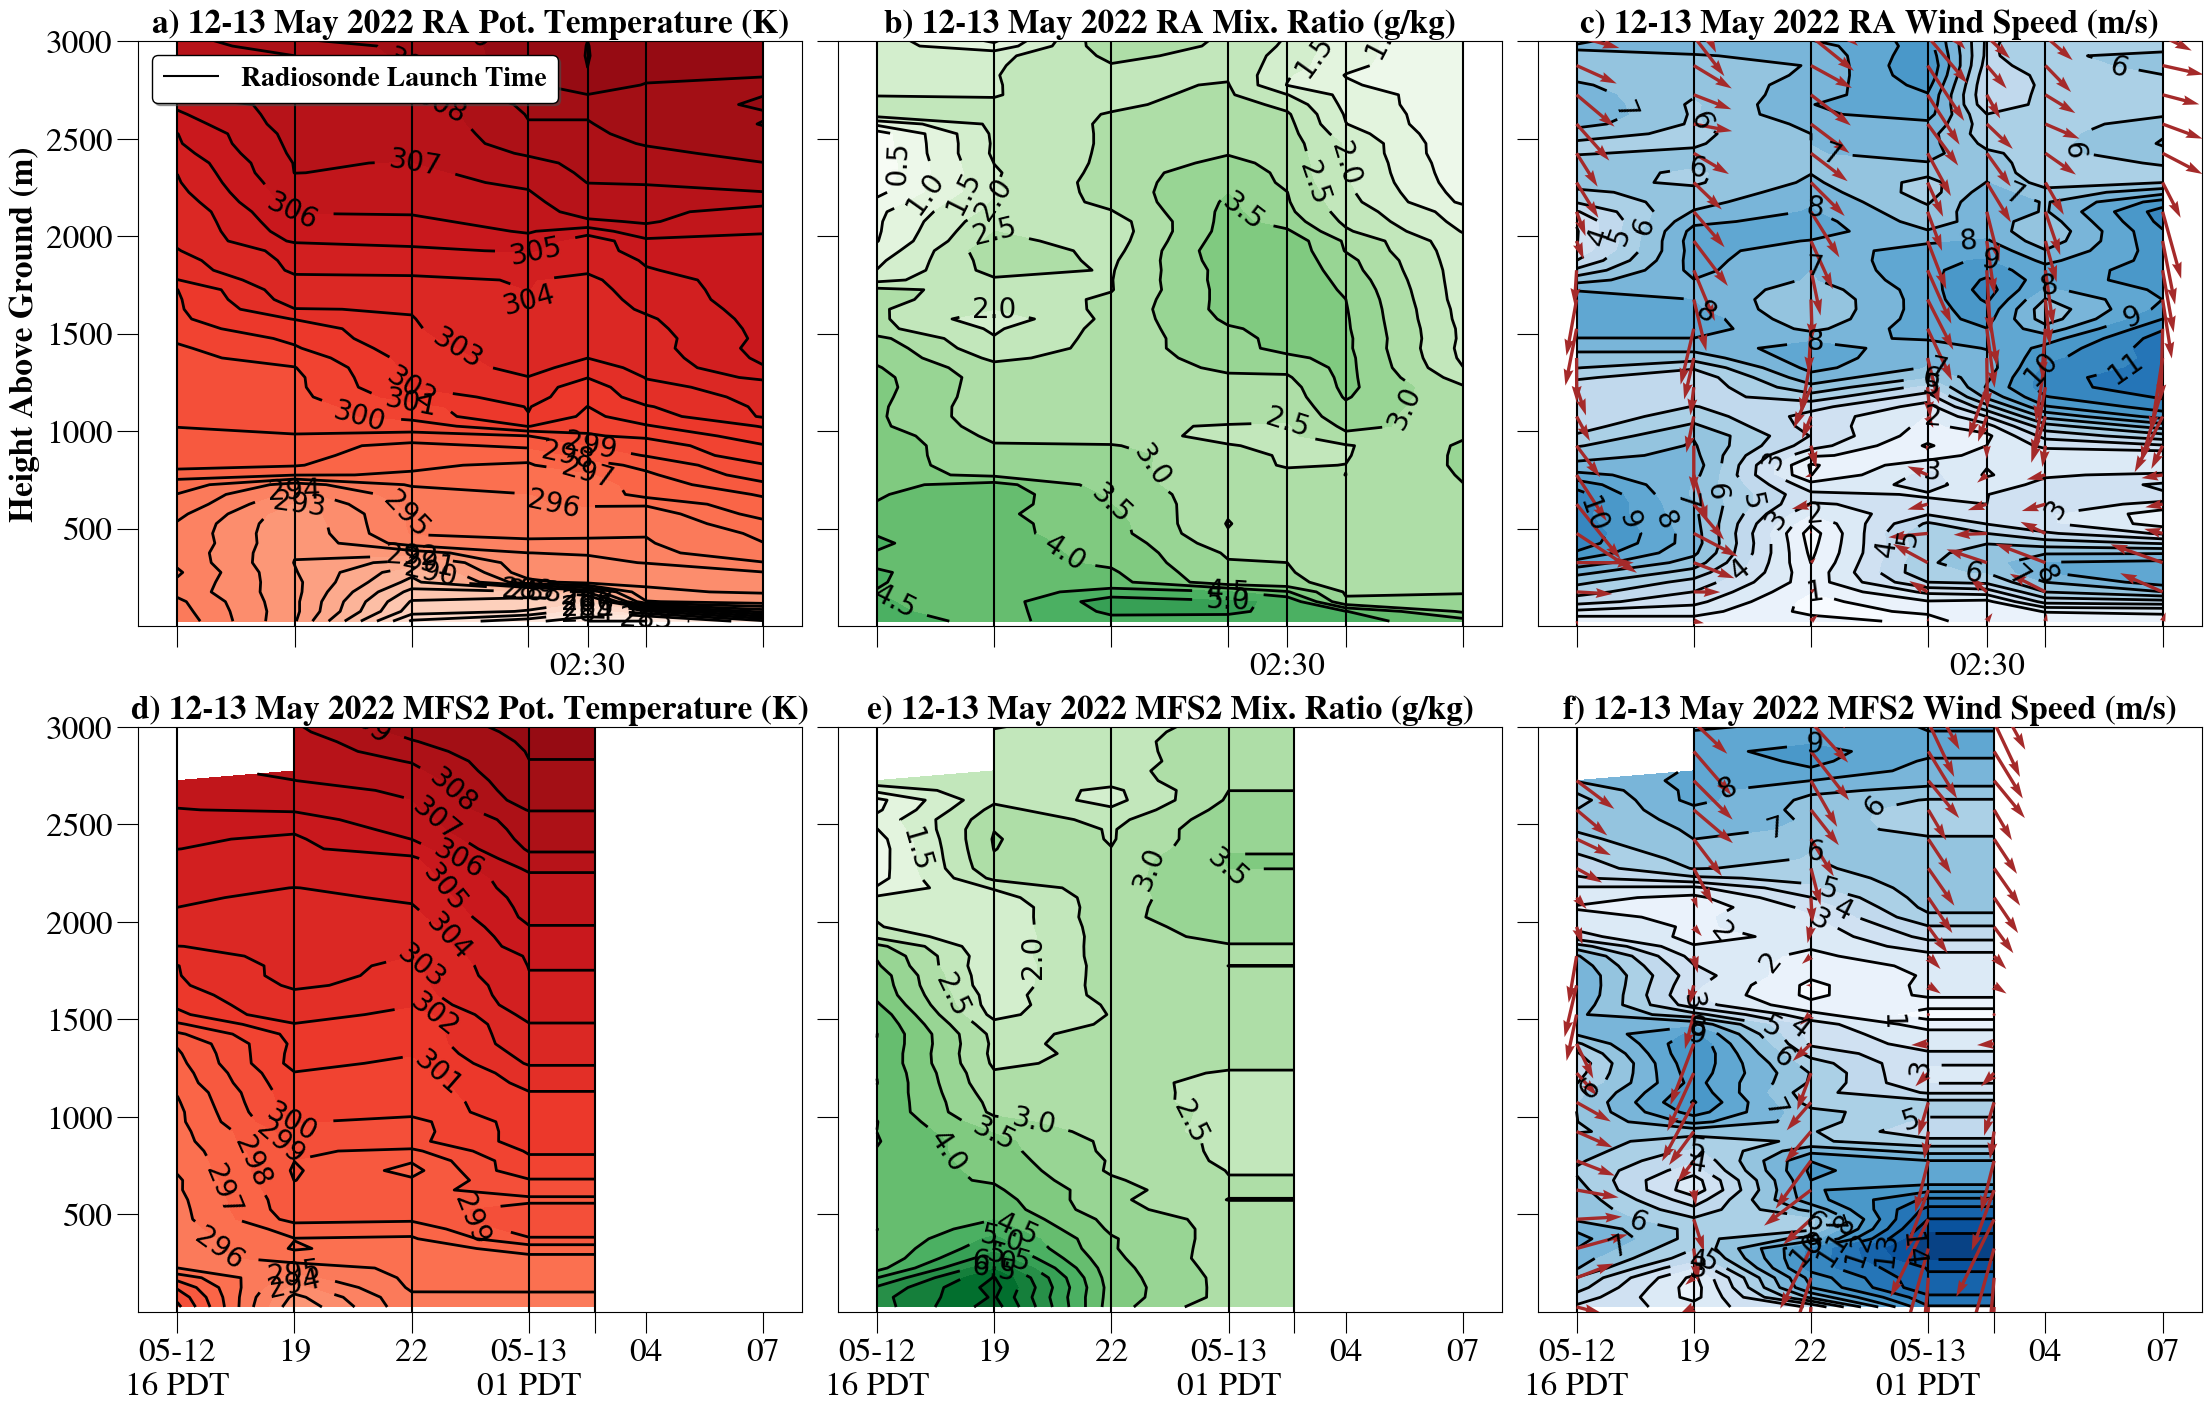

In [8]:
#----------------------------------------------------------------------------------------------------------------------
#Create figure and axis for plotting
fig, axs = plt.subplots(figsize=(22,14), nrows=2, ncols=3, constrained_layout=True)

#Define font dictionaries for plotting
fontdict_clabel_labels  = {'fontsize': 20}
fontdict_legend_labels  = {'size': 20, 'weight': 'bold', 'family':'Nimbus Roman'}
fontdict_xtick_labels   = {'fontsize': 24, 'fontweight': 'normal', 'fontname': 'Nimbus Roman'}
fontdict_ytick_labels   = {'fontsize': 24, 'fontweight': 'normal', 'fontname': 'Nimbus Roman'}
fontdict_axis_labels    = {'fontsize': 24, 'fontweight': 'bold', 'fontname': 'Nimbus Roman'}
fontdict_title_labels   = {'fontsize': 24, 'fontweight': 'bold', 'fontname': 'Nimbus Roman'}
#----------------------------------------------------------------------------------------------------------------------
for ax_index, ax in enumerate(axs.flatten()):
    
    #Add ticks longer
    ax.tick_params(axis='both', which='major', length=15)

    #For panels in the first column, do the following:
    if (ax_index == 0) | (ax_index == 3):

        #Define some levels for contourf
        contour_step = 1
        contour_min  = 280
        contour_max  = 314
        contour_levels = np.arange(contour_min, contour_max+contour_step, contour_step)

        #Define cmap for contourf and colorbar and set out of bound values
        contour_cmap = plt.get_cmap('Reds').copy()
        contour_cmap.set_extremes(under='white', over='black', bad='None')

        #Set the norm for contourf
        contour_norm = mcolors.BoundaryNorm(contour_levels, ncolors=contour_cmap.N, clip=False)
        
        #y-axis customizations
        y_min  = 0
        y_max  = 3000
        y_step = 500
        yticks = np.arange(y_min, y_max+y_step, y_step)
        ax.set_ylim([y_min, y_max])
        ax.set_yticks(yticks[1::])
        ax.set_yticklabels(yticks[1::], **fontdict_ytick_labels)
        
        #Rancho Alegre plotting items
        if ax_index == 0:
            
            #Define title string depending on launch site
            title_str = f'a) 12-13 May 2022 RA Pot. Temperature (K)'
            
            #Set the plotting variables
            dates_1d            = all_rancho_radiosondes_dates
            dates_2d            = all_rancho_radiosondes_dates_2d
            heights_midpoint_2d = all_rancho_radiosondes_height_above_grd_m_midpoint_2d
            variable_2d         = all_rancho_radiosondes_pot_temp_k_averaged_2d
            uwind_2d            = all_rancho_radiosondes_uwind_ms_averaged_2d*1.94384
            vwind_2d            = all_rancho_radiosondes_vwind_ms_averaged_2d*1.94384
            
            #x-axis customizations
            xticks_utc  = dates_1d
            xticks_pdt  = [xtick_utc - np.timedelta64(7, 'h') for xtick_utc in xticks_utc]
            xticklabels = ['', '', '', '', '02:30', '', '']            
            ax.set_xlim([xticks_utc[0] - np.timedelta64(1, 'h'), xticks_utc[-1] + np.timedelta64(1, 'h')])
            ax.set_xticks(xticks_utc)
            ax.set_xticklabels(xticklabels, **fontdict_xtick_labels)
            
            #y-axis customizations
            ax.set_ylabel('Height Above Ground (m)', **fontdict_axis_labels)
            
        #Montecito plotting items
        elif ax_index == 3: 
            
            #Define title string depending on launch site
            title_str = f'd) 12-13 May 2022 MFS2 Pot. Temperature (K)'
            
            #Set the plotting variables
            dates_1d            = all_montecito_radiosondes_dates
            dates_2d            = all_montecito_radiosondes_dates_2d
            heights_midpoint_2d = all_montecito_radiosondes_height_above_grd_m_midpoint_2d
            variable_2d         = all_montecito_radiosondes_pot_temp_k_averaged_2d
            uwind_2d            = all_montecito_radiosondes_uwind_ms_averaged_2d*1.94384
            vwind_2d            = all_montecito_radiosondes_vwind_ms_averaged_2d*1.94384
            
            #x-axis customizations
            xticks_utc  = dates_1d + [pd.to_datetime('2022-05-13 11:00'), pd.to_datetime('2022-05-13 14:00')]
            xticks_pdt  = [xtick_utc - np.timedelta64(7, 'h') for xtick_utc in xticks_utc]
            xticklabels = ['05-12\n16 PDT', '19', '22', '05-13\n01 PDT', ' ', '04', '07']
            ax.set_xlim([xticks_utc[0] - np.timedelta64(1, 'h'), xticks_utc[-1] + np.timedelta64(1, 'h')])
            ax.set_xticks(xticks_utc)
            ax.set_xticklabels(xticklabels, **fontdict_xtick_labels)
        
        #Plot filled contours, as well as contour lines
        contourf_plot = ax.contourf(dates_2d, heights_midpoint_2d, variable_2d, contour_levels, cmap=contour_cmap, norm=contour_norm)
        contour_lines = ax.contour(contourf_plot, contour_levels, colors='black', linewidths=2, linestyles='solid')

        #Add in labels for cotour lines
        ax.clabel(contour_lines, fmt='%2.0f', colors='black', **fontdict_clabel_labels)
        
        #If one the first plot, do the following
        if ax_index == 0: 
            #Add in vertical lines that show the radiosonde launch times and associated data (with legend)
            ax.vlines(dates_1d, 0, y_max, colors='black', label='Radiosonde Launch Time')
            
            #Add legend to first subplot only
            ax.legend(loc='upper left', ncol=1, fancybox=True, shadow=True, framealpha=1, facecolor='white', edgecolor='black', prop=fontdict_legend_labels)
        else:
            #Add in vertical lines that show the radiosonde launch times and associated data (without legend)
            ax.vlines(dates_1d, 0, y_max, colors='black')

        #General axis customizations
        ax.set_title(title_str, **fontdict_title_labels)
#----------------------------------------------------------------------------------------------------------------------
    #For panels in the second column, do the following:
    if (ax_index == 1) | (ax_index == 4):

        #Define some levels for contourf
        contour_step = 0.5
        contour_min  = 0
        contour_max  = 8
        contour_levels = np.arange(contour_min, contour_max+contour_step, contour_step)

        #Define cmap for contourf and colorbar and set out of bound values
        contour_cmap = plt.get_cmap('Greens').copy()
        contour_cmap.set_extremes(under='white', over='black', bad='None')

        #Set the norm for contourf
        contour_norm = mcolors.BoundaryNorm(contour_levels, ncolors=contour_cmap.N, clip=False)
        
        #y-axis customizations
        y_min  = 0
        y_max  = 3000
        y_step = 500
        yticks = np.arange(y_min, y_max+y_step, y_step)
        ax.set_ylim([y_min, y_max])
        ax.set_yticks(yticks[1::])
        ax.set_yticklabels([], **fontdict_ytick_labels)
        
        #Rancho Alegre plotting items
        if ax_index == 1:
            
            #Define title string depending on launch site
            title_str = f'b) 12-13 May 2022 RA Mix. Ratio (g/kg)'
            
            #Set the plotting variables
            dates_1d            = all_rancho_radiosondes_dates
            dates_2d            = all_rancho_radiosondes_dates_2d
            heights_midpoint_2d = all_rancho_radiosondes_height_above_grd_m_midpoint_2d
            variable_2d         = all_rancho_radiosondes_mix_ratio_g_averaged_2d
            
            #x-axis customizations
            xticks_utc  = dates_1d
            xticks_pdt  = [xtick_utc - np.timedelta64(7, 'h') for xtick_utc in xticks_utc]
            xticklabels = ['', '', '', '', '02:30', '', '']            
            ax.set_xlim([xticks_utc[0] - np.timedelta64(1, 'h'), xticks_utc[-1] + np.timedelta64(1, 'h')])
            ax.set_xticks(xticks_utc)
            ax.set_xticklabels(xticklabels, **fontdict_xtick_labels)
        
        #Montecito plotting items
        elif ax_index == 4: 
            
            #Define title string depending on launch site
            title_str = f'e) 12-13 May 2022 MFS2 Mix. Ratio (g/kg)'
            
            #Set the plotting variables
            dates_1d            = all_montecito_radiosondes_dates
            dates_2d            = all_montecito_radiosondes_dates_2d
            heights_midpoint_2d = all_montecito_radiosondes_height_above_grd_m_midpoint_2d
            variable_2d         = all_montecito_radiosondes_mix_ratio_g_averaged_2d
            
            #x-axis customizations
            xticks_utc  = dates_1d + [pd.to_datetime('2022-05-13 11:00'), pd.to_datetime('2022-05-13 14:00')]
            xticks_pdt  = [xtick_utc - np.timedelta64(7, 'h') for xtick_utc in xticks_utc]
            xticklabels = ['05-12\n16 PDT', '19', '22', '05-13\n01 PDT', ' ', '04', '07']
            ax.set_xlim([xticks_utc[0] - np.timedelta64(1, 'h'), xticks_utc[-1] + np.timedelta64(1, 'h')])
            ax.set_xticks(xticks_utc)
            ax.set_xticklabels(xticklabels, **fontdict_xtick_labels)
        
        #Plot filled contours, as well as contour lines
        contourf_plot = ax.contourf(dates_2d, heights_midpoint_2d, variable_2d, contour_levels, cmap=contour_cmap, norm=contour_norm)
        contour_lines = ax.contour(contourf_plot, contour_levels, colors='black', linewidths=2, linestyles='solid')

        #Add in labels for cotour lines
        ax.clabel(contour_lines, fmt='%2.1f', colors='black', **fontdict_clabel_labels)
        
        #Add in vertical lines that show the radiosonde launch times and associated data
        ax.vlines(dates_1d, 0, y_max, colors='black')

        #General axis customizations
        ax.set_title(title_str, **fontdict_title_labels)
#----------------------------------------------------------------------------------------------------------------------
    #For panels in the third column, do the following:
    if (ax_index == 2) | (ax_index == 5):

        #Define some levels for contourf
        contour_step = 1
        contour_min  = 0
        contour_max  = 16
        contour_levels = np.arange(contour_min, contour_max+contour_step, contour_step)

        #Define cmap for contourf and colorbar and set out of bound values
        contour_cmap = plt.get_cmap('Blues').copy()
        contour_cmap.set_extremes(under='white', over='black', bad='None')

        #Set the norm for contourf
        contour_norm = mcolors.BoundaryNorm(contour_levels, ncolors=contour_cmap.N, clip=False)
        
        #y-axis customizations
        y_min  = 0
        y_max  = 3000
        y_step = 500
        yticks = np.arange(y_min, y_max+y_step, y_step)
        ax.set_ylim([y_min, y_max])
        ax.set_yticks(yticks[1::])
        ax.set_yticklabels([], **fontdict_ytick_labels)
        
        #Rancho Alegre plotting items
        if ax_index == 2:
            
            #Define title string depending on launch site
            title_str = f'c) 12-13 May 2022 RA Wind Speed (m/s)'
            
            #Set the plotting variables
            dates_1d            = all_rancho_radiosondes_dates
            dates_2d            = all_rancho_radiosondes_dates_2d
            heights_midpoint_2d = all_rancho_radiosondes_height_above_grd_m_midpoint_2d
            variable_2d         = all_rancho_radiosondes_wind_speed_ms_averaged_2d
            uwind_2d            = all_rancho_radiosondes_uwind_ms_averaged_2d
            vwind_2d            = all_rancho_radiosondes_vwind_ms_averaged_2d
            
            #x-axis customizations
            xticks_utc  = dates_1d
            xticks_pdt  = [xtick_utc - np.timedelta64(7, 'h') for xtick_utc in xticks_utc]
            xticklabels = ['', '', '', '', '02:30', '', '']
            ax.set_xlim([xticks_utc[0] - np.timedelta64(1, 'h'), xticks_utc[-1] + np.timedelta64(1, 'h')])
            ax.set_xticks(xticks_utc)
            ax.set_xticklabels(xticklabels, **fontdict_xtick_labels)
        
        #Montecito plotting items
        elif ax_index == 5: 
            
            #Define title string depending on launch site
            title_str = f'f) 12-13 May 2022 MFS2 Wind Speed (m/s)'
            
            #Set the plotting variables
            dates_1d            = all_montecito_radiosondes_dates
            dates_2d            = all_montecito_radiosondes_dates_2d
            heights_midpoint_2d = all_montecito_radiosondes_height_above_grd_m_midpoint_2d
            variable_2d         = all_montecito_radiosondes_wind_speed_ms_averaged_2d
            uwind_2d            = all_montecito_radiosondes_uwind_ms_averaged_2d
            vwind_2d            = all_montecito_radiosondes_vwind_ms_averaged_2d
            
            #x-axis customizations
            xticks_utc  = dates_1d + [pd.to_datetime('2022-05-13 11:00'), pd.to_datetime('2022-05-13 14:00')]
            xticks_pdt  = [xtick_utc - np.timedelta64(7, 'h') for xtick_utc in xticks_utc]
            xticklabels = ['05-12\n16 PDT', '19', '22', '05-13\n01 PDT', ' ', '04', '07']
            ax.set_xlim([xticks_utc[0] - np.timedelta64(1, 'h'), xticks_utc[-1] + np.timedelta64(1, 'h')])
            ax.set_xticks(xticks_utc)
            ax.set_xticklabels(xticklabels, **fontdict_xtick_labels)
        
        #Plot filled contours, as well as contour lines
        contourf_plot = ax.contourf(dates_2d, heights_midpoint_2d, variable_2d, contour_levels, cmap=contour_cmap, norm=contour_norm)
        contour_lines = ax.contour(contourf_plot, contour_levels, colors='black', linewidths=2, linestyles='solid')

        #Add in labels for cotour lines
        ax.clabel(contour_lines, fmt='%2.0f', colors='black', **fontdict_clabel_labels)
        
        quiver_density_int = 3 
        quiver = ax.quiver(dates_2d[::quiver_density_int,:], 
                           heights_midpoint_2d[::quiver_density_int,:], 
                           uwind_2d[::quiver_density_int,:], 
                           vwind_2d[::quiver_density_int,:], 
                           color='brown', scale=100, width=0.005, zorder=3)
        
        #Add in vertical lines that show the radiosonde launch times and associated data
        ax.vlines(dates_1d, 0, y_max, colors='black')

        #General axis customizations
        ax.set_title(title_str, **fontdict_title_labels)
#----------------------------------------------------------------------------------------------------------------------        
#Save Figure
plt.savefig('./figures/figure_07_radiosonde_observations.png', bbox_inches='tight', dpi=300)

#Show figure
plt.show()
#----------------------------------------------------------------------------------------------------------------------